In [1]:
import copy

import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import json

In [2]:
filename = '/Users/tsievert/GA Caltech/QAE_4_HEP/ga_runs/run-2023-10-24_13-09-45/final_evolution_results.json'

dict = None
with open(filename, 'r') as f: # open in readonly mode
    dict = json.load(f)

In [3]:
print(dict.keys())

dict_keys(['full_population_vectors', 'full_population_drawings', 'final_max_vector_moments', 'full_population_fitness', 'full_tsne_data', 'per_gen_diversity', 'full_pop_diversity', 'current_generation', 'current_drawn_generation', 'current_generation_fitness', 'fitness_stats', 'best_ansatz', 'best_drawn_ansatz', 'best_fitness', 'best_fitness_gen', 'best_fitness_ix', 'full_population_metrics', 'eval_metrics', 'eval_metrics_stats', 'best_eval_metrics'])


In [4]:
full_pop_drawn_circuits = dict['full_population_drawings']
full_pop_fitness = dict['full_population_fitness']
full_pop_auroc = [i['auroc'] for i in dict['full_population_metrics']]
full_tsne_data = dict['full_tsne_data']
per_gen_diversity = dict['per_gen_diversity']

In [5]:
sorted_auroc = [i.item() for i in np.argsort(full_pop_auroc)]

In [6]:
print(f'median is: {np.median(full_pop_auroc)}')
print(f'iqr is: {scp.stats.iqr(full_pop_auroc)}')

median is: 0.8494153846153847
iqr is: 0.16738461538461524


In [7]:
print(f"auroc = {dict['best_eval_metrics']['auroc']}")
print(f"fitness = {dict['best_fitness']}")
print(dict['best_drawn_ansatz'])
print(f"gen = {dict['best_fitness_gen']}, index = {dict['best_fitness_ix']}")

auroc = 0.709374358974359
fitness = 0.9890395
0: ─────╭●─────╭X─────╭●──RZ─┤     
1: ──RX─│───Rϕ─│───RY─│──────┤     
2: ─────╰X─────╰●──Rϕ─╰X─────┤  
gen = 14, index = 1


In [8]:
worst_indeces = sorted_auroc[:]

for circuit_ix in worst_indeces:
    print(f'auroc = {full_pop_auroc[circuit_ix]}')
    print(f"fitness = {full_pop_fitness[circuit_ix]}")
    print(full_pop_drawn_circuits[circuit_ix])
    print(f'\n{"-"*40}\n')

auroc = 0
fitness = 0
0: ────────────────────────────────┤ 
1: ────────────────────────────────┤ 
2: ────────────────────────────────┤  

----------------------------------------

auroc = 0.06691282051282052
fitness = 0.9571485
0: ─────╭X──RX─────╭●─────┤     
1: ──RX─│───RZ──Rϕ─│──────┤     
2: ─────╰●─────────╰X──RX─┤  

----------------------------------------

auroc = 0.10036923076923077
fitness = 0.354244
0: ──RX─╭●─────╭X──RZ─┤     
1: ──RY─│───Rϕ─│──────┤     
2: ─────╰X─────╰●──RX─┤  

----------------------------------------

auroc = 0.10687179487179488
fitness = 0.6676934999999999
0: ─╭X──────╭X──RX─────┤     
1: ─╰●───RX─│───Rϕ─────┤     
2: ──RY─────╰●──RX──RZ─┤  

----------------------------------------

auroc = 0.10982564102564102
fitness = 0.30671099999999996
0: ─╭X─╭●─────╭X─────────┤     
1: ─╰●─│───RX─│──────────┤     
2: ────╰X──RX─╰●──Rϕ──RZ─┤  

----------------------------------------

auroc = 0.12188717948717949
fitness = 0.914887
0: ──RX─────╭●──RX─────┤     
1

In [9]:
import ga_vqc as gav

gates_dict = {"I": (1, 0), "RX": (1, 1), "RY": (1, 1), "RZ": (1, 1), "PhaseShift": (1, 1), "CNOT": (2, 0)}
gates_probs = [0.15, 0.15, 0.15, 0.15, 0.15, 0.25]
genepool = gav.Genepool(gates_dict, gates_probs)

full_pop_circuits = []
for diagram in full_pop_drawn_circuits:
    full_pop_circuits.append(gav.Individual(3, 1, 1, genepool, rng_seed=None, diagram=diagram))

max_vector_moments = 0
for circuit in full_pop_circuits:
    if circuit.n_moments > max_vector_moments:
        max_vector_moments = circuit.n_moments

for circuit in full_pop_circuits:
    circuit.generate_vector(max_vector_moments)

In [10]:
## Euclidean Distances ##

euc_distances = []

for i in range(len(full_pop_circuits)):
    euc_distances.append(gav.euclidean_distances(full_pop_circuits[i], full_pop_circuits[0], full_pop_circuits[1:]))
calc_distances = np.array(euc_distances)
euc_distances = np.hstack(([[0]]+[[1] for _ in range(len(full_pop_circuits)-1)], euc_distances))

euc_cutoff_threshold = 0.9
euc_groupings = []
set_of_euc_picked = set()

for i in range(1, len(full_pop_circuits)):
    if i in set_of_euc_picked:
        continue
    current_group = [i]
    set_of_euc_picked.add(i)

    for j in range(1, len(full_pop_circuits)):
        if j <= i or j in set_of_euc_picked:
            continue
        
        add_flag = True
        for k in current_group:
            if euc_distances[k, j] >= euc_cutoff_threshold:
                add_flag = False
        if add_flag:
            current_group.append(j)
            set_of_euc_picked.add(j)

    euc_groupings.append(copy.deepcopy(current_group))

In [11]:
for group in euc_groupings:    
    for j in group:
        print('-'*30)
        print(f'fitness = {full_pop_fitness[j]:.03f}, auroc = {full_pop_auroc[j]:.03f}')
        print(full_pop_drawn_circuits[j])
    print('='*50)

------------------------------
fitness = 0.810, auroc = 0.689
0: ──Rϕ──RY─────────┤     
1: ─────╭●───RY─────┤     
2: ──RY─╰X───RX──Rϕ─┤  
------------------------------
fitness = 0.802, auroc = 0.868
0: ──Rϕ─╭X──────────────┤     
1: ─────╰●───RZ──Rϕ──RZ─┤     
2: ──RY──RZ──RX──Rϕ─────┤  
------------------------------
fitness = 0.802, auroc = 0.877
0: ─────╭●──RZ─────┤     
1: ──RZ─│───Rϕ─────┤     
2: ─────╰X──Rϕ──RZ─┤  
------------------------------
fitness = 0.878, auroc = 0.870
0: ─────╭●─────────┤     
1: ──RZ─│──────────┤     
2: ─────╰X──RX──RY─┤  
------------------------------
fitness = 0.754, auroc = 0.871
0: ─────╭X─────────┤     
1: ──RZ─│───Rϕ─────┤     
2: ─────╰●──RZ──RY─┤  
------------------------------
fitness = 0.909, auroc = 0.873
0: ──RY──RX─┤     
1: ──RX─────┤     
2: ──Rϕ──RX─┤  
------------------------------
fitness = 0.031, auroc = 0.575
0: ──Rϕ──RX─┤     
1: ──RX──RZ─┤     
2: ──Rϕ──RX─┤  
------------------------------
fitness = 0.738, auroc = 0.874
0: 

In [12]:
def order(calc_distances, calc_groupings):
    ordering = []
    set_of_picked = set()

    ordering.append(0)
    set_of_picked.add(0)

    for _ in range(len(calc_groupings)-1):
        avg_arr = []
        for j in range(len(calc_groupings)):
            avg_distances = []
            for m in calc_groupings[ordering[-1]]:
                distances = []
                for n in calc_groupings[j]:
                    distances.append(calc_distances[m, n])
                avg_distances.append(np.mean(distances).item())
            
            avg_arr.append(np.mean(avg_distances).item())
        
        index_avg_arr = np.argsort(avg_arr)
        for j in index_avg_arr:
            if j in set_of_picked:
                continue
            ordering.append(j)
            set_of_picked.add(j)
            break

    return ordering

In [13]:
euc_ordering = order(euc_distances, euc_groupings)

In [21]:
## String Distances ##

str_distances = []

for i in range(len(full_pop_circuits)):
    str_distances.append(gav.string_distances(full_pop_circuits[i], full_pop_circuits[0].diagram, full_pop_circuits[1:]))
str_distances = np.array(str_distances)
str_distances = np.hstack(([[0]]+[[1] for _ in range(len(full_pop_circuits)-1)], str_distances))

str_cutoff_threshold = 0.9
str_groupings = []
set_of_str_picked = set()

for i in range(1, len(full_pop_circuits)):
    if i in set_of_str_picked:
        continue
    current_group = [i]
    set_of_str_picked.add(i)

    for j in range(1, len(full_pop_circuits)):
        if j <= i or j in set_of_str_picked:
            continue
        
        add_flag = True
        for k in current_group:
            if str_distances[k, j] >= str_cutoff_threshold:
                add_flag = False
        if add_flag:
            current_group.append(j)
            set_of_str_picked.add(j)

    str_groupings.append(copy.deepcopy(current_group))

In [22]:
for group in str_groupings:    
    for j in group:
        print('-'*30)
        print(f'fitness = {full_pop_fitness[j]:.03f}, auroc = {full_pop_auroc[j]:.03f}')
        print(full_pop_drawn_circuits[j])
    print('='*50)

------------------------------
fitness = 0.810, auroc = 0.689
0: ──Rϕ──RY─────────┤     
1: ─────╭●───RY─────┤     
2: ──RY─╰X───RX──Rϕ─┤  
------------------------------
fitness = 0.909, auroc = 0.873
0: ──RY──RX─┤     
1: ──RX─────┤     
2: ──Rϕ──RX─┤  
------------------------------
fitness = 0.839, auroc = 0.875
0: ─────╭●──Rϕ──RZ─┤     
1: ─────│───Rϕ─────┤     
2: ──Rϕ─╰X──RY─────┤  
------------------------------
fitness = 0.853, auroc = 0.857
0: ─────╭X──RY─╭X───RX─┤     
1: ──RX─│───RY─╰●──────┤     
2: ─────╰●──RZ──RY──RX─┤  
------------------------------
fitness = 0.802, auroc = 0.877
0: ─────╭●──RZ─────┤     
1: ──RZ─│───Rϕ─────┤     
2: ─────╰X──Rϕ──RZ─┤  
------------------------------
fitness = 0.962, auroc = 0.683
0: ──Rϕ──RX──RY─────┤     
1: ──RZ──RX──RZ──RY─┤     
2: ──RY──RX──RZ──RY─┤  
------------------------------
fitness = 0.968, auroc = 0.871
0: ──Rϕ──RZ────────┤     
1: ──Rϕ─────╭X──RY─┤     
2: ──RX──RY─╰●──RX─┤  
------------------------------
fitness = 0.7

In [23]:
str_ordering = order(str_distances, str_groupings)

In [17]:
import matplotlib as mpl

cmap = plt.cm.jet # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0, len(euc_groupings)-1, len(euc_groupings))
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

In [29]:
import mpld3

def interactive_plot(ordering, groupings, method: str, n_plot_groupings=10):
    tags = [0 for _ in range(len(full_pop_auroc))]
    for i in range(len(full_pop_auroc)):
        found_flag = False
        for k in range(len(groupings)):
            if found_flag:
                break
            for j in groupings[k]:
                if j == i:
                    return_index = 0
                    for m in range(len(groupings)):
                        if ordering[m] == k:
                            return_index = m
                            break
                    found_flag = True
                    tags[i] = return_index
                    break

    point_labels = [point_label for point_label in zip(range(len(full_pop_auroc)), tags)]

    for i in range((len(groupings) // n_plot_groupings) + 1):
        break_flag = False
        if ((i+1)*n_plot_groupings) + n_plot_groupings >= len(euc_groupings):
            n_plot_groupings = len(groupings) - ((i*n_plot_groupings) + n_plot_groupings)
            break_flag = True
            
        bounds = np.linspace(i*n_plot_groupings, ((i+1)*n_plot_groupings), n_plot_groupings+1)
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

        index_arr = []
        for j in range(len(tags)):
            if tags[j] in set(range(i*n_plot_groupings, (i+1)*n_plot_groupings)):
                index_arr.append(j)
                
        sub_tags = [tags[j] for j in index_arr]
        sub_labels = [point_labels[j] for j in index_arr]
        sub_x = [full_pop_fitness[j] for j in index_arr]
        sub_y = [full_pop_auroc[j] for j in index_arr]

        fig, ax = plt.subplots(1)
        points = ax.scatter(sub_x, sub_y, c=sub_tags,
            cmap=cmap, norm=norm, marker='.')
        ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
        cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
            spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')

        ax.set_title('Colorized groupings of circuit performace')
        ax2.set_ylabel('Grouping cbar [-]', size=12)
        ax.set_xlabel('fidelity', size=12)
        ax.set_ylabel('auroc', size=12)

        mpld3.plugins.connect(fig, mpld3.plugins.PointLabelTooltip(points, sub_labels))

        html = mpld3.fig_to_html(fig)
        print(html)

        mpld3.save_html(fig, 'html/interactive_scatter_%s_%d.html' % (method, i))

        plt.show(1)
        plt.close(1)

        if break_flag:
            break



<style>

</style>

<div id="fig_el366481405401078010723009185247"></div>
<script>
function mpld3_load_lib(url, callback){
  var s = document.createElement('script');
  s.src = url;
  s.async = true;
  s.onreadystatechange = s.onload = callback;
  s.onerror = function(){console.warn("failed to load library " + url);};
  document.getElementsByTagName("head")[0].appendChild(s);
}

if(typeof(mpld3) !== "undefined" && mpld3._mpld3IsLoaded){
   // already loaded: just create the figure
   !function(mpld3){
       
       mpld3.draw_figure("fig_el366481405401078010723009185247", {"width": 640.0, "height": 480.0, "axes": [{"bbox": [0.125, 0.10999999999999999, 0.775, 0.77], "xlim": [-0.049336625, 1.036069125], "ylim": [-0.04457435897435898, 0.9360615384615385], "xdomain": [-0.049336625, 1.036069125], "ydomain": [-0.04457435897435898, 0.9360615384615385], "xscale": "linear", "yscale": "linear", "axes": [{"position": "bottom", "nticks": 8, "tickvalues": null, "tickformat_formatter": "", "tickfo

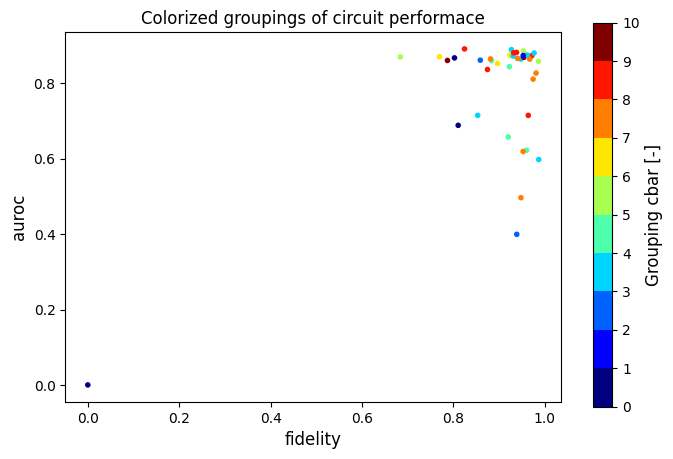



<style>

</style>

<div id="fig_el366481405400785280644627511565"></div>
<script>
function mpld3_load_lib(url, callback){
  var s = document.createElement('script');
  s.src = url;
  s.async = true;
  s.onreadystatechange = s.onload = callback;
  s.onerror = function(){console.warn("failed to load library " + url);};
  document.getElementsByTagName("head")[0].appendChild(s);
}

if(typeof(mpld3) !== "undefined" && mpld3._mpld3IsLoaded){
   // already loaded: just create the figure
   !function(mpld3){
       
       mpld3.draw_figure("fig_el366481405400785280644627511565", {"width": 640.0, "height": 480.0, "axes": [{"bbox": [0.125, 0.10999999999999999, 0.775, 0.77], "xlim": [-0.04552235000000001, 0.99456835], "ylim": [0.06796, 0.9240194871794871], "xdomain": [-0.04552235000000001, 0.99456835], "ydomain": [0.06796, 0.9240194871794871], "xscale": "linear", "yscale": "linear", "axes": [{"position": "bottom", "nticks": 7, "tickvalues": null, "tickformat_formatter": "", "tickformat": null,

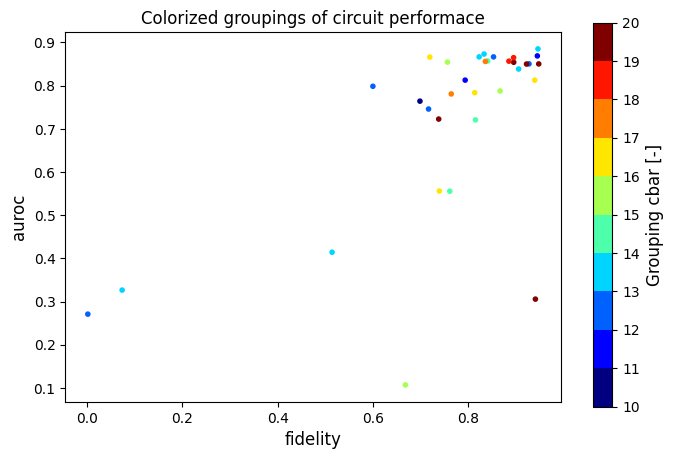



<style>

</style>

<div id="fig_el366481405401038562406620516651"></div>
<script>
function mpld3_load_lib(url, callback){
  var s = document.createElement('script');
  s.src = url;
  s.async = true;
  s.onreadystatechange = s.onload = callback;
  s.onerror = function(){console.warn("failed to load library " + url);};
  document.getElementsByTagName("head")[0].appendChild(s);
}

if(typeof(mpld3) !== "undefined" && mpld3._mpld3IsLoaded){
   // already loaded: just create the figure
   !function(mpld3){
       
       mpld3.draw_figure("fig_el366481405401038562406620516651", {"width": 640.0, "height": 480.0, "axes": [{"bbox": [0.125, 0.10999999999999999, 0.775, 0.77], "xlim": [-0.053583074999999925, 1.0133525749999999], "ylim": [0.08373333333333333, 0.9231179487179488], "xdomain": [-0.053583074999999925, 1.0133525749999999], "ydomain": [0.08373333333333333, 0.9231179487179488], "xscale": "linear", "yscale": "linear", "axes": [{"position": "bottom", "nticks": 8, "tickvalues": null, "tick

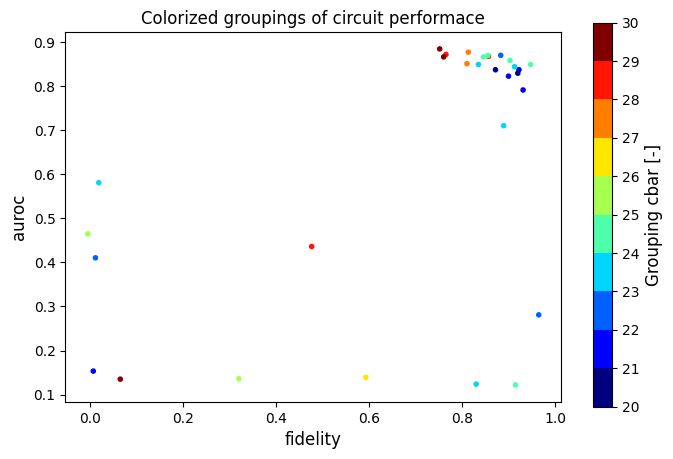



<style>

</style>

<div id="fig_el366481405400683275843797478526"></div>
<script>
function mpld3_load_lib(url, callback){
  var s = document.createElement('script');
  s.src = url;
  s.async = true;
  s.onreadystatechange = s.onload = callback;
  s.onerror = function(){console.warn("failed to load library " + url);};
  document.getElementsByTagName("head")[0].appendChild(s);
}

if(typeof(mpld3) !== "undefined" && mpld3._mpld3IsLoaded){
   // already loaded: just create the figure
   !function(mpld3){
       
       mpld3.draw_figure("fig_el366481405400683275843797478526", {"width": 640.0, "height": 480.0, "axes": [{"bbox": [0.125, 0.10999999999999999, 0.775, 0.77], "xlim": [-0.04887507500000001, 1.025012575], "ylim": [0.3521928205128205, 0.9188225641025641], "xdomain": [-0.04887507500000001, 1.025012575], "ydomain": [0.3521928205128205, 0.9188225641025641], "xscale": "linear", "yscale": "linear", "axes": [{"position": "bottom", "nticks": 8, "tickvalues": null, "tickformat_formatter":

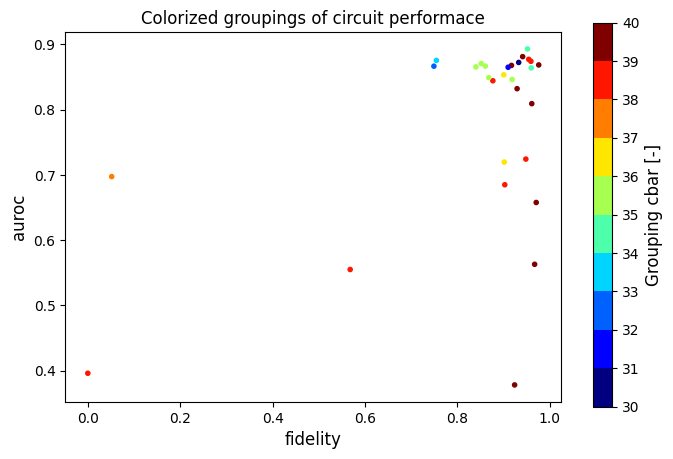



<style>

</style>

<div id="fig_el366481405400743087529718221049"></div>
<script>
function mpld3_load_lib(url, callback){
  var s = document.createElement('script');
  s.src = url;
  s.async = true;
  s.onreadystatechange = s.onload = callback;
  s.onerror = function(){console.warn("failed to load library " + url);};
  document.getElementsByTagName("head")[0].appendChild(s);
}

if(typeof(mpld3) !== "undefined" && mpld3._mpld3IsLoaded){
   // already loaded: just create the figure
   !function(mpld3){
       
       mpld3.draw_figure("fig_el366481405400743087529718221049", {"width": 640.0, "height": 480.0, "axes": [{"bbox": [0.125, 0.10999999999999999, 0.775, 0.77], "xlim": [-0.025315624999999904, 1.037342125], "ylim": [0.06115794871794872, 0.9238061538461537], "xdomain": [-0.025315624999999904, 1.037342125], "ydomain": [0.06115794871794872, 0.9238061538461537], "xscale": "linear", "yscale": "linear", "axes": [{"position": "bottom", "nticks": 8, "tickvalues": null, "tickformat_formatt

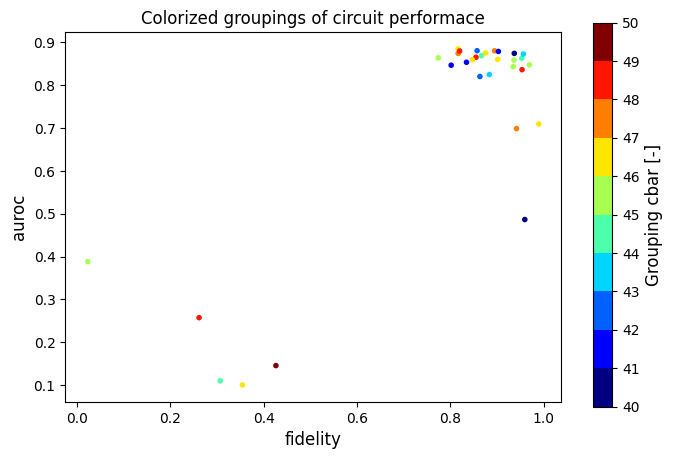



<style>

</style>

<div id="fig_el366481405400671300003621618157"></div>
<script>
function mpld3_load_lib(url, callback){
  var s = document.createElement('script');
  s.src = url;
  s.async = true;
  s.onreadystatechange = s.onload = callback;
  s.onerror = function(){console.warn("failed to load library " + url);};
  document.getElementsByTagName("head")[0].appendChild(s);
}

if(typeof(mpld3) !== "undefined" && mpld3._mpld3IsLoaded){
   // already loaded: just create the figure
   !function(mpld3){
       
       mpld3.draw_figure("fig_el366481405400671300003621618157", {"width": 640.0, "height": 480.0, "axes": [{"bbox": [0.125, 0.10999999999999999, 0.775, 0.77], "xlim": [-0.00461767500000005, 1.020993175], "ylim": [0.026271794871794873, 0.9203743589743592], "xdomain": [-0.00461767500000005, 1.020993175], "ydomain": [0.026271794871794873, 0.9203743589743592], "xscale": "linear", "yscale": "linear", "axes": [{"position": "bottom", "nticks": 8, "tickvalues": null, "tickformat_formatt

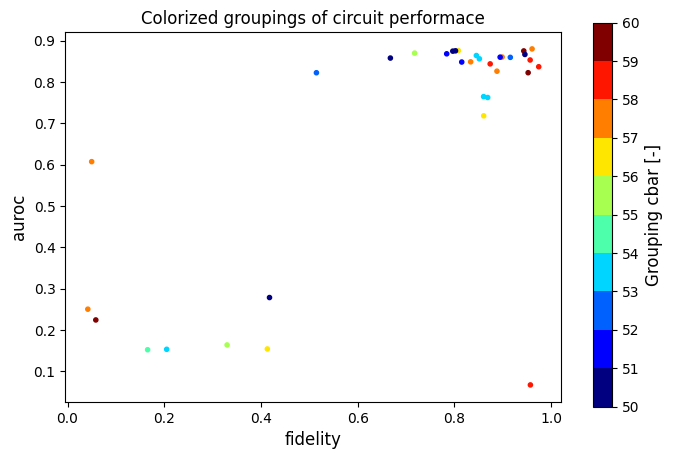



<style>

</style>

<div id="fig_el366481405400978206569965451852"></div>
<script>
function mpld3_load_lib(url, callback){
  var s = document.createElement('script');
  s.src = url;
  s.async = true;
  s.onreadystatechange = s.onload = callback;
  s.onerror = function(){console.warn("failed to load library " + url);};
  document.getElementsByTagName("head")[0].appendChild(s);
}

if(typeof(mpld3) !== "undefined" && mpld3._mpld3IsLoaded){
   // already loaded: just create the figure
   !function(mpld3){
       
       mpld3.draw_figure("fig_el366481405400978206569965451852", {"width": 640.0, "height": 480.0, "axes": [{"bbox": [0.125, 0.10999999999999999, 0.775, 0.77], "xlim": [-0.01237882500000001, 1.013873325], "ylim": [0.11404410256410254, 0.9107148717948718], "xdomain": [-0.01237882500000001, 1.013873325], "ydomain": [0.11404410256410254, 0.9107148717948718], "xscale": "linear", "yscale": "linear", "axes": [{"position": "bottom", "nticks": 8, "tickvalues": null, "tickformat_formatter

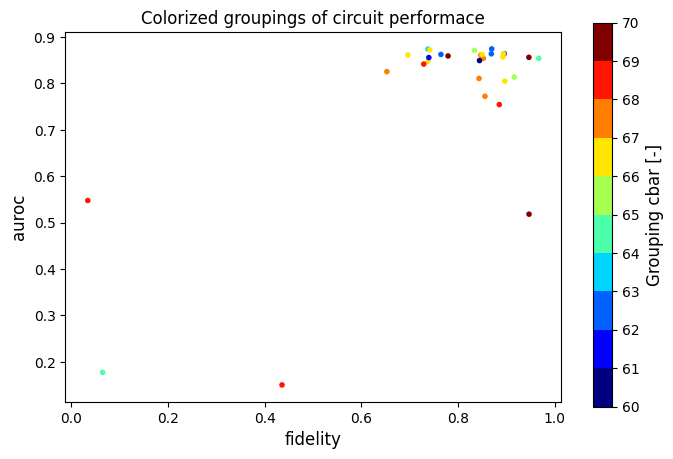



<style>

</style>

<div id="fig_el366481405400862371208136011693"></div>
<script>
function mpld3_load_lib(url, callback){
  var s = document.createElement('script');
  s.src = url;
  s.async = true;
  s.onreadystatechange = s.onload = callback;
  s.onerror = function(){console.warn("failed to load library " + url);};
  document.getElementsByTagName("head")[0].appendChild(s);
}

if(typeof(mpld3) !== "undefined" && mpld3._mpld3IsLoaded){
   // already loaded: just create the figure
   !function(mpld3){
       
       mpld3.draw_figure("fig_el366481405400862371208136011693", {"width": 640.0, "height": 480.0, "axes": [{"bbox": [0.125, 0.10999999999999999, 0.775, 0.77], "xlim": [0.004539624999999943, 0.982128875], "ylim": [0.18643076923076923, 0.9096102564102565], "xdomain": [0.004539624999999943, 0.982128875], "ydomain": [0.18643076923076923, 0.9096102564102565], "xscale": "linear", "yscale": "linear", "axes": [{"position": "bottom", "nticks": 6, "tickvalues": null, "tickformat_formatter

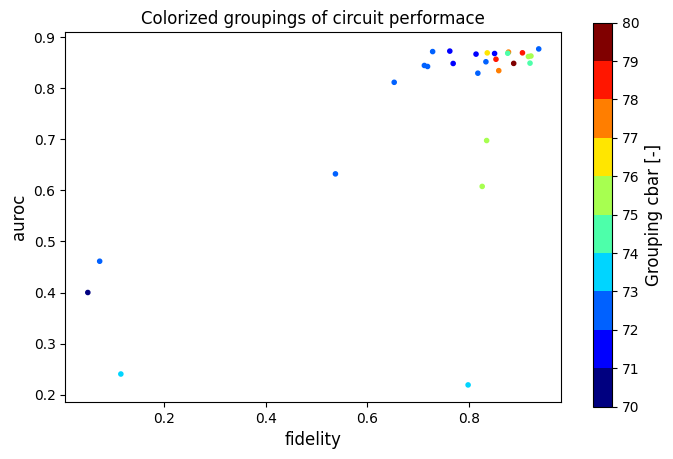



<style>

</style>

<div id="fig_el366481405401194251842525780558"></div>
<script>
function mpld3_load_lib(url, callback){
  var s = document.createElement('script');
  s.src = url;
  s.async = true;
  s.onreadystatechange = s.onload = callback;
  s.onerror = function(){console.warn("failed to load library " + url);};
  document.getElementsByTagName("head")[0].appendChild(s);
}

if(typeof(mpld3) !== "undefined" && mpld3._mpld3IsLoaded){
   // already loaded: just create the figure
   !function(mpld3){
       
       mpld3.draw_figure("fig_el366481405401194251842525780558", {"width": 640.0, "height": 480.0, "axes": [{"bbox": [0.125, 0.10999999999999999, 0.775, 0.77], "xlim": [0.041529850000000035, 0.99245015], "ylim": [0.09684820512820512, 0.9171210256410256], "xdomain": [0.041529850000000035, 0.99245015], "ydomain": [0.09684820512820512, 0.9171210256410256], "xscale": "linear", "yscale": "linear", "axes": [{"position": "bottom", "nticks": 6, "tickvalues": null, "tickformat_formatter":

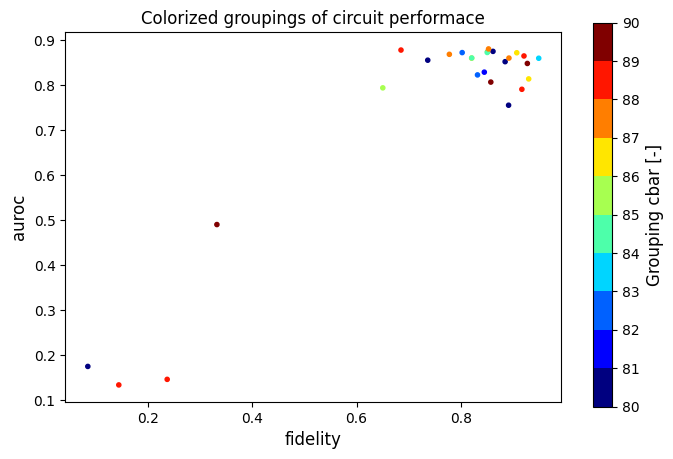



<style>

</style>

<div id="fig_el366481405401119445764275890778"></div>
<script>
function mpld3_load_lib(url, callback){
  var s = document.createElement('script');
  s.src = url;
  s.async = true;
  s.onreadystatechange = s.onload = callback;
  s.onerror = function(){console.warn("failed to load library " + url);};
  document.getElementsByTagName("head")[0].appendChild(s);
}

if(typeof(mpld3) !== "undefined" && mpld3._mpld3IsLoaded){
   // already loaded: just create the figure
   !function(mpld3){
       
       mpld3.draw_figure("fig_el366481405401119445764275890778", {"width": 640.0, "height": 480.0, "axes": [{"bbox": [0.125, 0.10999999999999999, 0.775, 0.77], "xlim": [0.03063342499999991, 0.995753075], "ylim": [0.2184533333333334, 0.9352697435897436], "xdomain": [0.03063342499999991, 0.995753075], "ydomain": [0.2184533333333334, 0.9352697435897436], "xscale": "linear", "yscale": "linear", "axes": [{"position": "bottom", "nticks": 6, "tickvalues": null, "tickformat_formatter": "

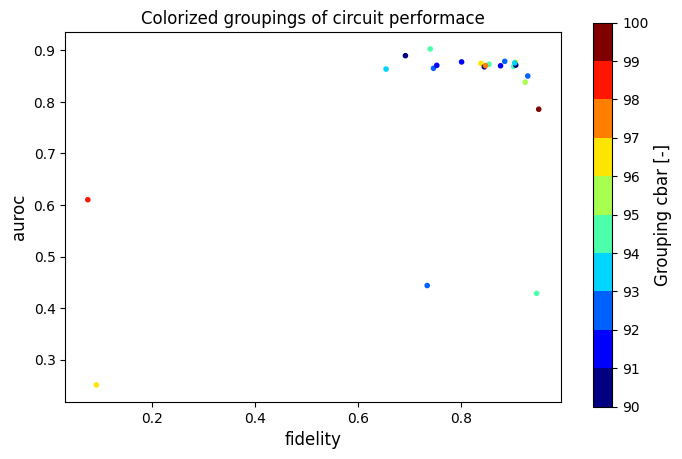



<style>

</style>

<div id="fig_el366481405400709684329479268889"></div>
<script>
function mpld3_load_lib(url, callback){
  var s = document.createElement('script');
  s.src = url;
  s.async = true;
  s.onreadystatechange = s.onload = callback;
  s.onerror = function(){console.warn("failed to load library " + url);};
  document.getElementsByTagName("head")[0].appendChild(s);
}

if(typeof(mpld3) !== "undefined" && mpld3._mpld3IsLoaded){
   // already loaded: just create the figure
   !function(mpld3){
       
       mpld3.draw_figure("fig_el366481405400709684329479268889", {"width": 640.0, "height": 480.0, "axes": [{"bbox": [0.125, 0.10999999999999999, 0.775, 0.77], "xlim": [-0.06988132500000022, 1.017343825], "ylim": [0.10896820512820514, 0.9117087179487179], "xdomain": [-0.06988132500000022, 1.017343825], "ydomain": [0.10896820512820514, 0.9117087179487179], "xscale": "linear", "yscale": "linear", "axes": [{"position": "bottom", "nticks": 8, "tickvalues": null, "tickformat_formatter

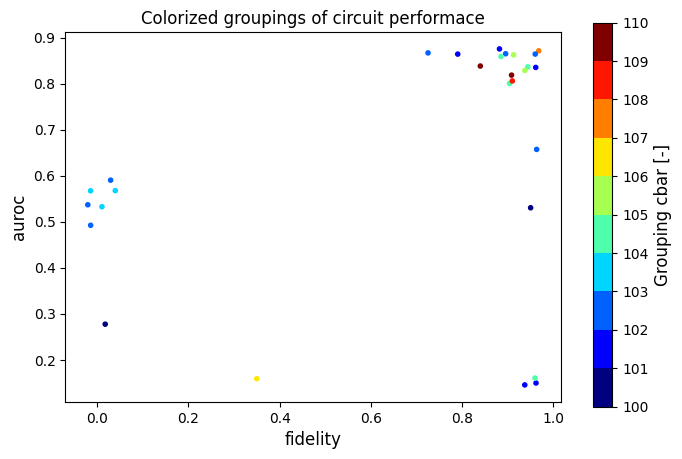



<style>

</style>

<div id="fig_el366481405401053455369011965838"></div>
<script>
function mpld3_load_lib(url, callback){
  var s = document.createElement('script');
  s.src = url;
  s.async = true;
  s.onreadystatechange = s.onload = callback;
  s.onerror = function(){console.warn("failed to load library " + url);};
  document.getElementsByTagName("head")[0].appendChild(s);
}

if(typeof(mpld3) !== "undefined" && mpld3._mpld3IsLoaded){
   // already loaded: just create the figure
   !function(mpld3){
       
       mpld3.draw_figure("fig_el366481405401053455369011965838", {"width": 640.0, "height": 480.0, "axes": [{"bbox": [0.125, 0.10999999999999999, 0.775, 0.77], "xlim": [-0.04058130000000015, 1.0059213], "ylim": [0.42892615384615385, 0.8990943589743589], "xdomain": [-0.04058130000000015, 1.0059213], "ydomain": [0.42892615384615385, 0.8990943589743589], "xscale": "linear", "yscale": "linear", "axes": [{"position": "bottom", "nticks": 8, "tickvalues": null, "tickformat_formatter": "

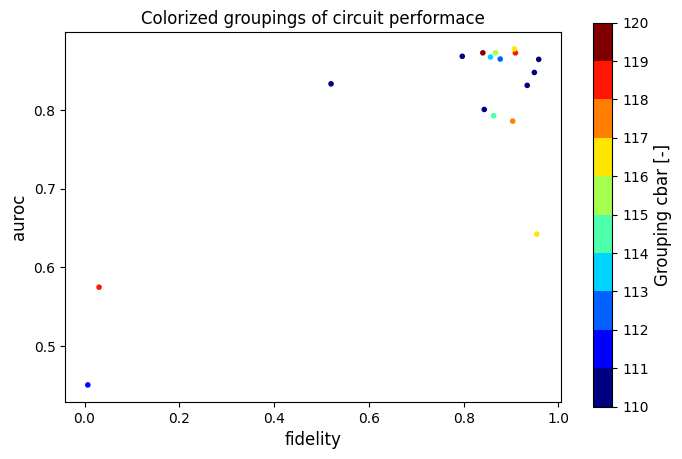



<style>

</style>

<div id="fig_el366481405400848974402529904748"></div>
<script>
function mpld3_load_lib(url, callback){
  var s = document.createElement('script');
  s.src = url;
  s.async = true;
  s.onreadystatechange = s.onload = callback;
  s.onerror = function(){console.warn("failed to load library " + url);};
  document.getElementsByTagName("head")[0].appendChild(s);
}

if(typeof(mpld3) !== "undefined" && mpld3._mpld3IsLoaded){
   // already loaded: just create the figure
   !function(mpld3){
       
       mpld3.draw_figure("fig_el366481405400848974402529904748", {"width": 640.0, "height": 480.0, "axes": [{"bbox": [0.125, 0.10999999999999999, 0.775, 0.77], "xlim": [-0.05039370000000002, 1.0127277000000001], "ylim": [0.15520307692307694, 0.9105815384615384], "xdomain": [-0.05039370000000002, 1.0127277000000001], "ydomain": [0.15520307692307694, 0.9105815384615384], "xscale": "linear", "yscale": "linear", "axes": [{"position": "bottom", "nticks": 8, "tickvalues": null, "tickfo

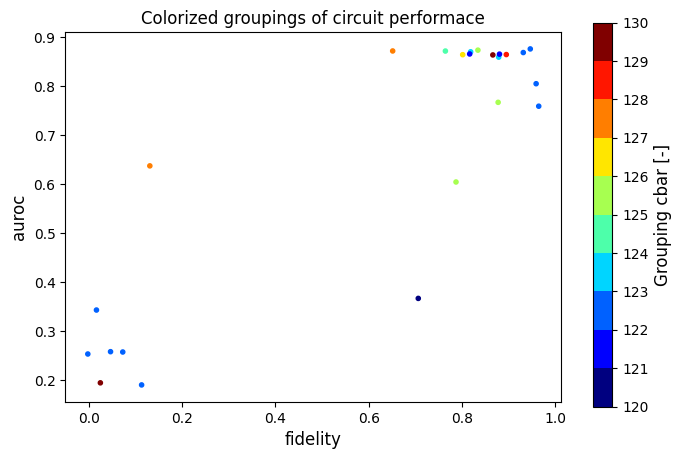



<style>

</style>

<div id="fig_el366481405400675018245725439350"></div>
<script>
function mpld3_load_lib(url, callback){
  var s = document.createElement('script');
  s.src = url;
  s.async = true;
  s.onreadystatechange = s.onload = callback;
  s.onerror = function(){console.warn("failed to load library " + url);};
  document.getElementsByTagName("head")[0].appendChild(s);
}

if(typeof(mpld3) !== "undefined" && mpld3._mpld3IsLoaded){
   // already loaded: just create the figure
   !function(mpld3){
       
       mpld3.draw_figure("fig_el366481405400675018245725439350", {"width": 640.0, "height": 480.0, "axes": [{"bbox": [0.125, 0.10999999999999999, 0.775, 0.77], "xlim": [0.04310617500000001, 0.995812325], "ylim": [0.20612512820512824, 0.9094030769230769], "xdomain": [0.04310617500000001, 0.995812325], "ydomain": [0.20612512820512824, 0.9094030769230769], "xscale": "linear", "yscale": "linear", "axes": [{"position": "bottom", "nticks": 6, "tickvalues": null, "tickformat_formatter":

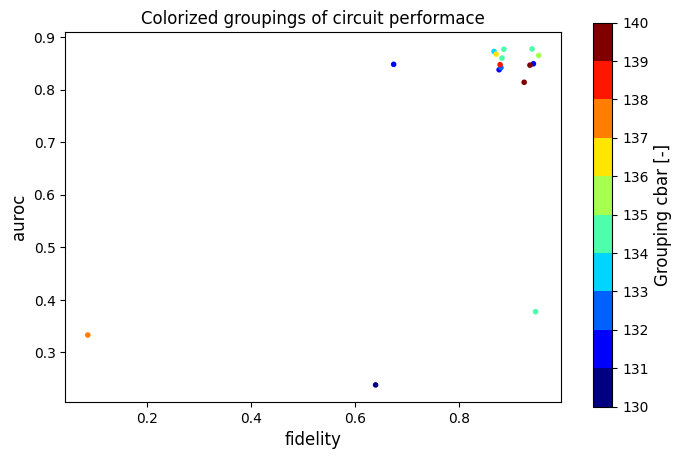



<style>

</style>

<div id="fig_el366481405401044502085886544266"></div>
<script>
function mpld3_load_lib(url, callback){
  var s = document.createElement('script');
  s.src = url;
  s.async = true;
  s.onreadystatechange = s.onload = callback;
  s.onerror = function(){console.warn("failed to load library " + url);};
  document.getElementsByTagName("head")[0].appendChild(s);
}

if(typeof(mpld3) !== "undefined" && mpld3._mpld3IsLoaded){
   // already loaded: just create the figure
   !function(mpld3){
       
       mpld3.draw_figure("fig_el366481405401044502085886544266", {"width": 640.0, "height": 480.0, "axes": [{"bbox": [0.125, 0.10999999999999999, 0.775, 0.77], "xlim": [0.10485749999999992, 0.9692815], "ylim": [0.09684820512820512, 0.9171210256410256], "xdomain": [0.10485749999999992, 0.9692815], "ydomain": [0.09684820512820512, 0.9171210256410256], "xscale": "linear", "yscale": "linear", "axes": [{"position": "bottom", "nticks": 10, "tickvalues": null, "tickformat_formatter": ""

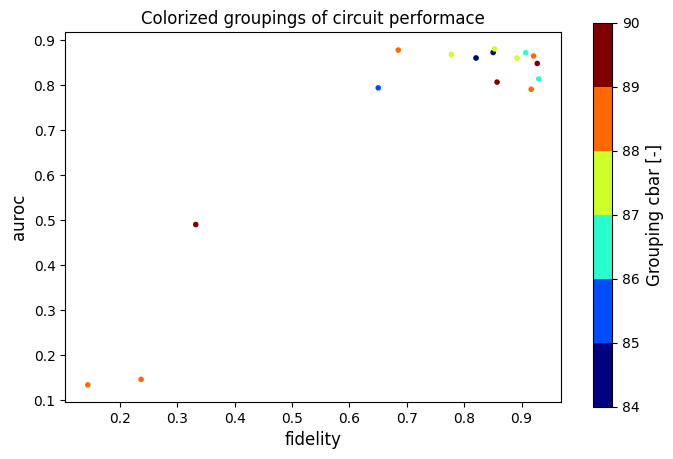

In [31]:
interactive_plot(euc_ordering, euc_groupings, 'euclid')



<style>

</style>

<div id="fig_el366481405400972857123232131168"></div>
<script>
function mpld3_load_lib(url, callback){
  var s = document.createElement('script');
  s.src = url;
  s.async = true;
  s.onreadystatechange = s.onload = callback;
  s.onerror = function(){console.warn("failed to load library " + url);};
  document.getElementsByTagName("head")[0].appendChild(s);
}

if(typeof(mpld3) !== "undefined" && mpld3._mpld3IsLoaded){
   // already loaded: just create the figure
   !function(mpld3){
       
       mpld3.draw_figure("fig_el366481405400972857123232131168", {"width": 640.0, "height": 480.0, "axes": [{"bbox": [0.125, 0.10999999999999999, 0.775, 0.77], "xlim": [-0.0484493, 1.0174353], "ylim": [-0.04387384615384615, 0.9213507692307692], "xdomain": [-0.0484493, 1.0174353], "ydomain": [-0.04387384615384615, 0.9213507692307692], "xscale": "linear", "yscale": "linear", "axes": [{"position": "bottom", "nticks": 8, "tickvalues": null, "tickformat_formatter": "", "tickformat": n

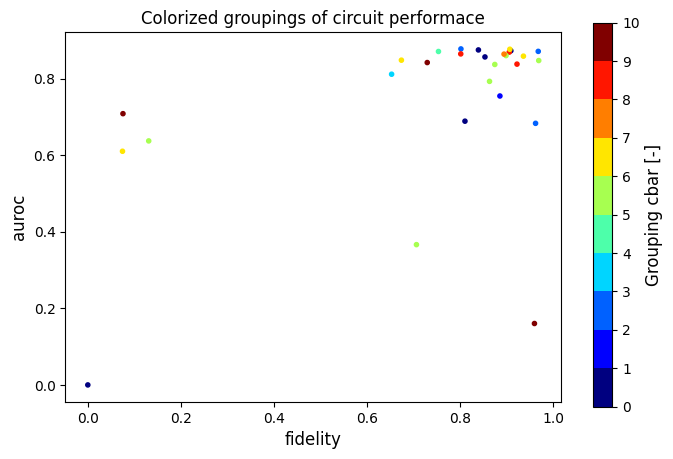



<style>

</style>

<div id="fig_el366481405400872548002314127419"></div>
<script>
function mpld3_load_lib(url, callback){
  var s = document.createElement('script');
  s.src = url;
  s.async = true;
  s.onreadystatechange = s.onload = callback;
  s.onerror = function(){console.warn("failed to load library " + url);};
  document.getElementsByTagName("head")[0].appendChild(s);
}

if(typeof(mpld3) !== "undefined" && mpld3._mpld3IsLoaded){
   // already loaded: just create the figure
   !function(mpld3){
       
       mpld3.draw_figure("fig_el366481405400872548002314127419", {"width": 640.0, "height": 480.0, "axes": [{"bbox": [0.125, 0.10999999999999999, 0.775, 0.77], "xlim": [-0.0362787249999999, 1.011014225], "ylim": [0.3865856410256411, 0.9136605128205127], "xdomain": [-0.0362787249999999, 1.011014225], "ydomain": [0.3865856410256411, 0.9136605128205127], "xscale": "linear", "yscale": "linear", "axes": [{"position": "bottom", "nticks": 8, "tickvalues": null, "tickformat_formatter": "

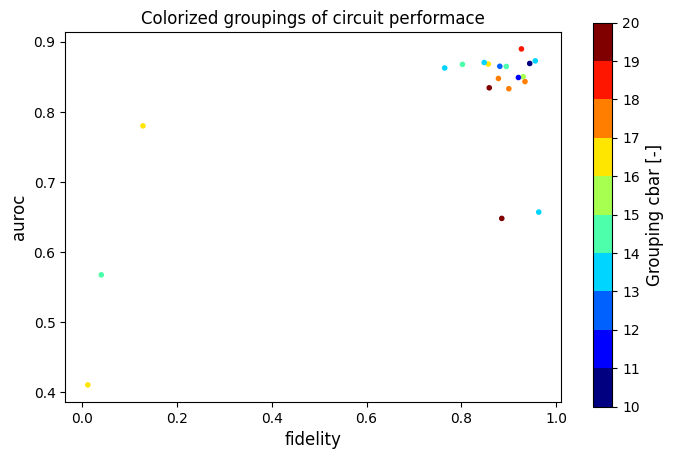



<style>

</style>

<div id="fig_el366481405400665497129160607102"></div>
<script>
function mpld3_load_lib(url, callback){
  var s = document.createElement('script');
  s.src = url;
  s.async = true;
  s.onreadystatechange = s.onload = callback;
  s.onerror = function(){console.warn("failed to load library " + url);};
  document.getElementsByTagName("head")[0].appendChild(s);
}

if(typeof(mpld3) !== "undefined" && mpld3._mpld3IsLoaded){
   // already loaded: just create the figure
   !function(mpld3){
       
       mpld3.draw_figure("fig_el366481405400665497129160607102", {"width": 640.0, "height": 480.0, "axes": [{"bbox": [0.125, 0.10999999999999999, 0.775, 0.77], "xlim": [-0.029081649999999876, 0.99932265], "ylim": [0.24725948717948718, 0.9097866666666667], "xdomain": [-0.029081649999999876, 0.99932265], "ydomain": [0.24725948717948718, 0.9097866666666667], "xscale": "linear", "yscale": "linear", "axes": [{"position": "bottom", "nticks": 7, "tickvalues": null, "tickformat_formatter

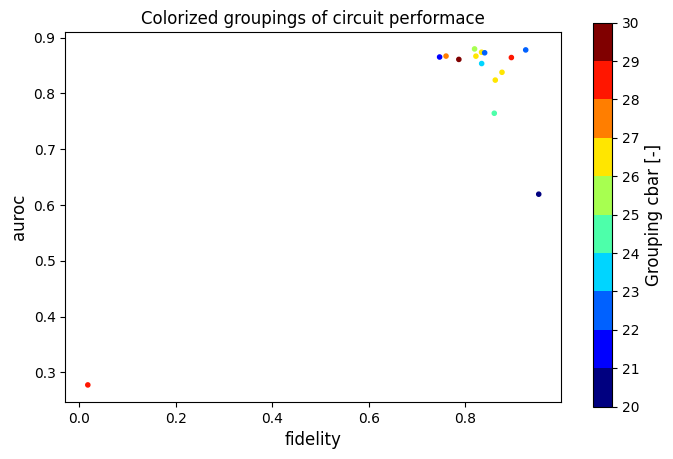



<style>

</style>

<div id="fig_el366481405400972827361511459222"></div>
<script>
function mpld3_load_lib(url, callback){
  var s = document.createElement('script');
  s.src = url;
  s.async = true;
  s.onreadystatechange = s.onload = callback;
  s.onerror = function(){console.warn("failed to load library " + url);};
  document.getElementsByTagName("head")[0].appendChild(s);
}

if(typeof(mpld3) !== "undefined" && mpld3._mpld3IsLoaded){
   // already loaded: just create the figure
   !function(mpld3){
       
       mpld3.draw_figure("fig_el366481405400972827361511459222", {"width": 640.0, "height": 480.0, "axes": [{"bbox": [0.125, 0.10999999999999999, 0.775, 0.77], "xlim": [-0.06382707500000004, 1.020587575], "ylim": [0.06840307692307693, 0.9147148717948718], "xdomain": [-0.06382707500000004, 1.020587575], "ydomain": [0.06840307692307693, 0.9147148717948718], "xscale": "linear", "yscale": "linear", "axes": [{"position": "bottom", "nticks": 8, "tickvalues": null, "tickformat_formatter

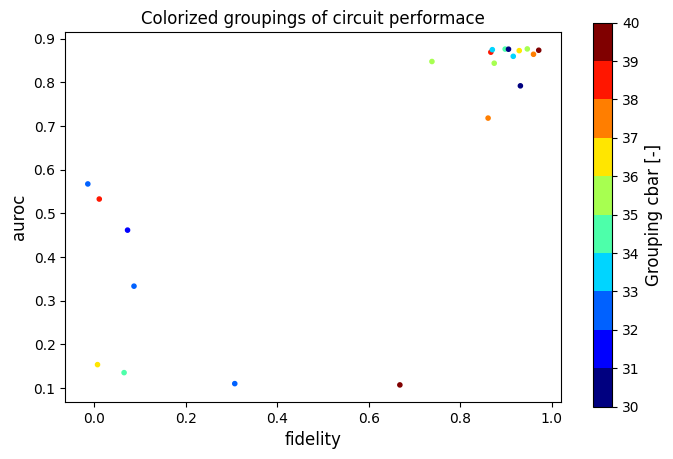



<style>

</style>

<div id="fig_el366481405401010667044706019364"></div>
<script>
function mpld3_load_lib(url, callback){
  var s = document.createElement('script');
  s.src = url;
  s.async = true;
  s.onreadystatechange = s.onload = callback;
  s.onerror = function(){console.warn("failed to load library " + url);};
  document.getElementsByTagName("head")[0].appendChild(s);
}

if(typeof(mpld3) !== "undefined" && mpld3._mpld3IsLoaded){
   // already loaded: just create the figure
   !function(mpld3){
       
       mpld3.draw_figure("fig_el366481405401010667044706019364", {"width": 640.0, "height": 480.0, "axes": [{"bbox": [0.125, 0.10999999999999999, 0.775, 0.77], "xlim": [-0.05479227499999992, 1.038745775], "ylim": [0.12280717948717951, 0.9184851282051283], "xdomain": [-0.05479227499999992, 1.038745775], "ydomain": [0.12280717948717951, 0.9184851282051283], "xscale": "linear", "yscale": "linear", "axes": [{"position": "bottom", "nticks": 8, "tickvalues": null, "tickformat_formatter

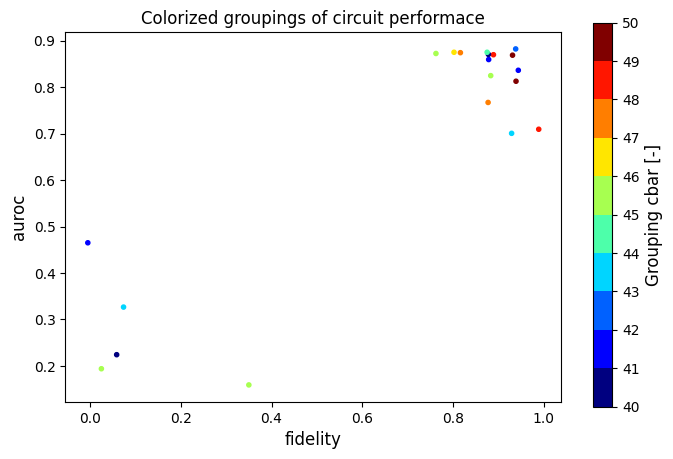



<style>

</style>

<div id="fig_el366481405400862383688343689480"></div>
<script>
function mpld3_load_lib(url, callback){
  var s = document.createElement('script');
  s.src = url;
  s.async = true;
  s.onreadystatechange = s.onload = callback;
  s.onerror = function(){console.warn("failed to load library " + url);};
  document.getElementsByTagName("head")[0].appendChild(s);
}

if(typeof(mpld3) !== "undefined" && mpld3._mpld3IsLoaded){
   // already loaded: just create the figure
   !function(mpld3){
       
       mpld3.draw_figure("fig_el366481405400862383688343689480", {"width": 640.0, "height": 480.0, "axes": [{"bbox": [0.125, 0.10999999999999999, 0.775, 0.77], "xlim": [-0.02871959999999997, 1.0116956000000001], "ylim": [0.16351179487179485, 0.9193189743589745], "xdomain": [-0.02871959999999997, 1.0116956000000001], "ydomain": [0.16351179487179485, 0.9193189743589745], "xscale": "linear", "yscale": "linear", "axes": [{"position": "bottom", "nticks": 8, "tickvalues": null, "tickfo

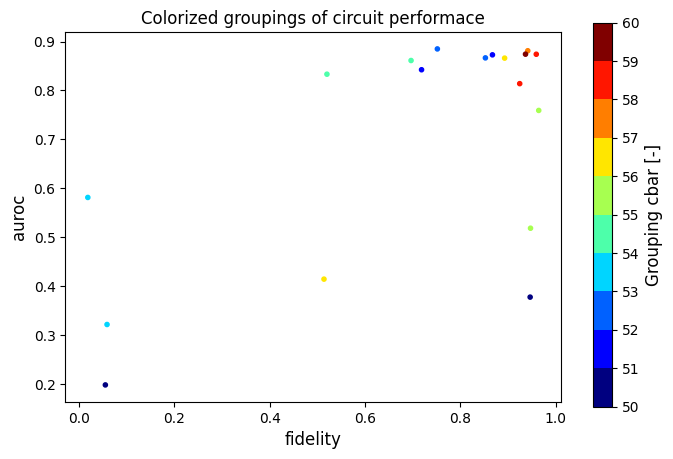



<style>

</style>

<div id="fig_el366481405401142980965131871258"></div>
<script>
function mpld3_load_lib(url, callback){
  var s = document.createElement('script');
  s.src = url;
  s.async = true;
  s.onreadystatechange = s.onload = callback;
  s.onerror = function(){console.warn("failed to load library " + url);};
  document.getElementsByTagName("head")[0].appendChild(s);
}

if(typeof(mpld3) !== "undefined" && mpld3._mpld3IsLoaded){
   // already loaded: just create the figure
   !function(mpld3){
       
       mpld3.draw_figure("fig_el366481405401142980965131871258", {"width": 640.0, "height": 480.0, "axes": [{"bbox": [0.125, 0.10999999999999999, 0.775, 0.77], "xlim": [-0.023873449999999907, 1.00705645], "ylim": [0.36300717948717953, 0.9146543589743589], "xdomain": [-0.023873449999999907, 1.00705645], "ydomain": [0.36300717948717953, 0.9146543589743589], "xscale": "linear", "yscale": "linear", "axes": [{"position": "bottom", "nticks": 8, "tickvalues": null, "tickformat_formatter

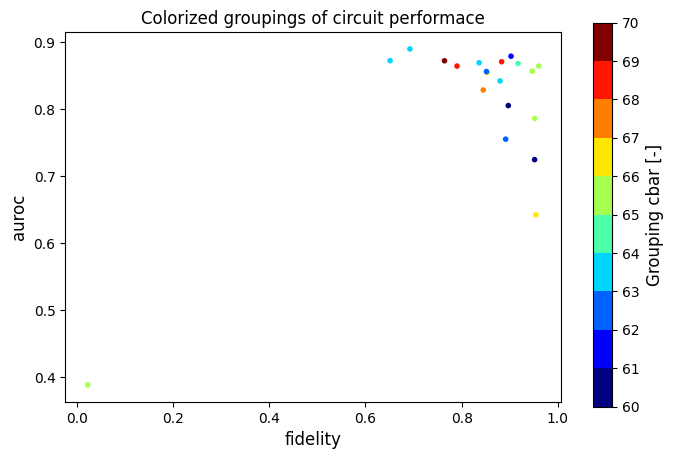



<style>

</style>

<div id="fig_el366481405401096023367676906089"></div>
<script>
function mpld3_load_lib(url, callback){
  var s = document.createElement('script');
  s.src = url;
  s.async = true;
  s.onreadystatechange = s.onload = callback;
  s.onerror = function(){console.warn("failed to load library " + url);};
  document.getElementsByTagName("head")[0].appendChild(s);
}

if(typeof(mpld3) !== "undefined" && mpld3._mpld3IsLoaded){
   // already loaded: just create the figure
   !function(mpld3){
       
       mpld3.draw_figure("fig_el366481405401096023367676906089", {"width": 640.0, "height": 480.0, "axes": [{"bbox": [0.125, 0.10999999999999999, 0.775, 0.77], "xlim": [-0.01608452500000005, 1.013857025], "ylim": [0.2054646153846154, 0.9232738461538461], "xdomain": [-0.01608452500000005, 1.013857025], "ydomain": [0.2054646153846154, 0.9232738461538461], "xscale": "linear", "yscale": "linear", "axes": [{"position": "bottom", "nticks": 8, "tickvalues": null, "tickformat_formatter":

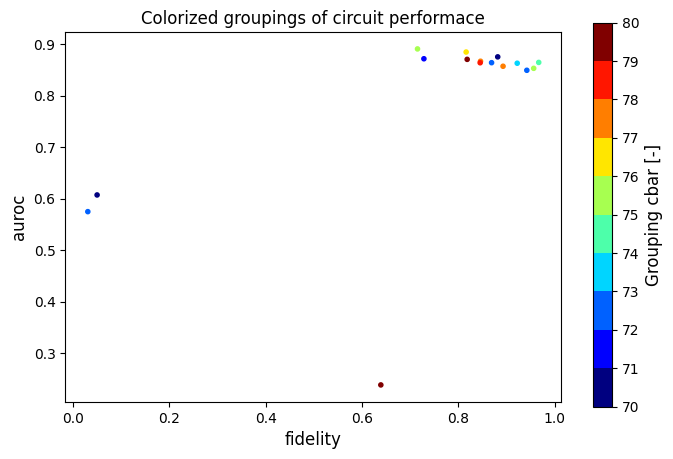



<style>

</style>

<div id="fig_el366481405400735463208832979355"></div>
<script>
function mpld3_load_lib(url, callback){
  var s = document.createElement('script');
  s.src = url;
  s.async = true;
  s.onreadystatechange = s.onload = callback;
  s.onerror = function(){console.warn("failed to load library " + url);};
  document.getElementsByTagName("head")[0].appendChild(s);
}

if(typeof(mpld3) !== "undefined" && mpld3._mpld3IsLoaded){
   // already loaded: just create the figure
   !function(mpld3){
       
       mpld3.draw_figure("fig_el366481405400735463208832979355", {"width": 640.0, "height": 480.0, "axes": [{"bbox": [0.125, 0.10999999999999999, 0.775, 0.77], "xlim": [0.009099825000000006, 1.006682675], "ylim": [0.11390256410256408, 0.9136871794871795], "xdomain": [0.009099825000000006, 1.006682675], "ydomain": [0.11390256410256408, 0.9136871794871795], "xscale": "linear", "yscale": "linear", "axes": [{"position": "bottom", "nticks": 7, "tickvalues": null, "tickformat_formatter

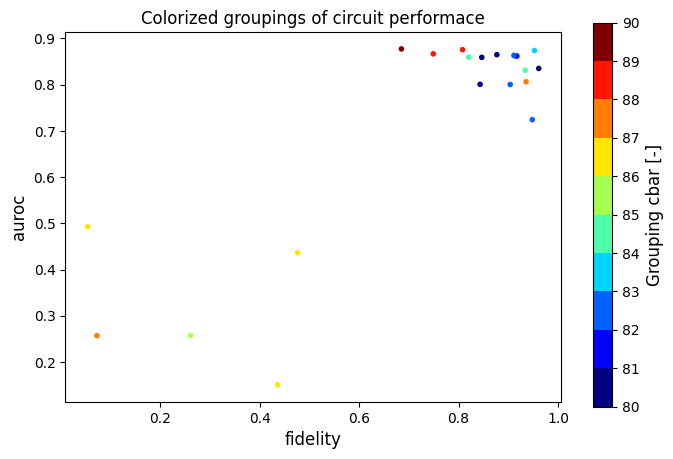



<style>

</style>

<div id="fig_el366481405401126096324075342320"></div>
<script>
function mpld3_load_lib(url, callback){
  var s = document.createElement('script');
  s.src = url;
  s.async = true;
  s.onreadystatechange = s.onload = callback;
  s.onerror = function(){console.warn("failed to load library " + url);};
  document.getElementsByTagName("head")[0].appendChild(s);
}

if(typeof(mpld3) !== "undefined" && mpld3._mpld3IsLoaded){
   // already loaded: just create the figure
   !function(mpld3){
       
       mpld3.draw_figure("fig_el366481405401126096324075342320", {"width": 640.0, "height": 480.0, "axes": [{"bbox": [0.125, 0.10999999999999999, 0.775, 0.77], "xlim": [-0.031268174999999926, 1.0181466750000001], "ylim": [0.21835794871794872, 0.9178676923076923], "xdomain": [-0.031268174999999926, 1.0181466750000001], "ydomain": [0.21835794871794872, 0.9178676923076923], "xscale": "linear", "yscale": "linear", "axes": [{"position": "bottom", "nticks": 8, "tickvalues": null, "tick

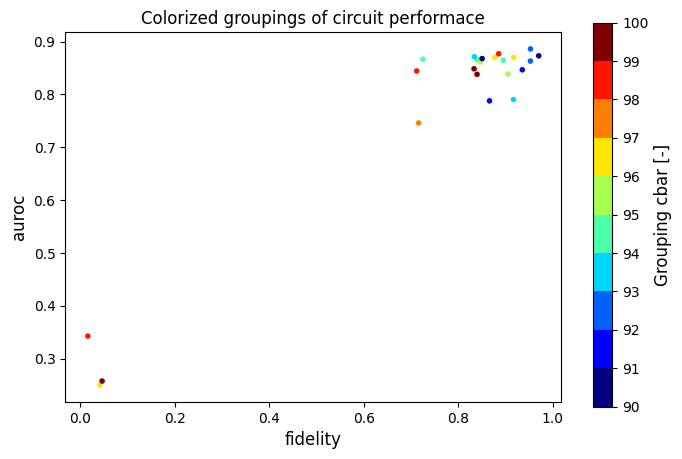



<style>

</style>

<div id="fig_el366481405401147178567149188790"></div>
<script>
function mpld3_load_lib(url, callback){
  var s = document.createElement('script');
  s.src = url;
  s.async = true;
  s.onreadystatechange = s.onload = callback;
  s.onerror = function(){console.warn("failed to load library " + url);};
  document.getElementsByTagName("head")[0].appendChild(s);
}

if(typeof(mpld3) !== "undefined" && mpld3._mpld3IsLoaded){
   // already loaded: just create the figure
   !function(mpld3){
       
       mpld3.draw_figure("fig_el366481405401147178567149188790", {"width": 640.0, "height": 480.0, "axes": [{"bbox": [0.125, 0.10999999999999999, 0.775, 0.77], "xlim": [-0.05120377500000002, 1.029739275], "ylim": [0.061401025641025626, 0.9187015384615386], "xdomain": [-0.05120377500000002, 1.029739275], "ydomain": [0.061401025641025626, 0.9187015384615386], "xscale": "linear", "yscale": "linear", "axes": [{"position": "bottom", "nticks": 8, "tickvalues": null, "tickformat_formatt

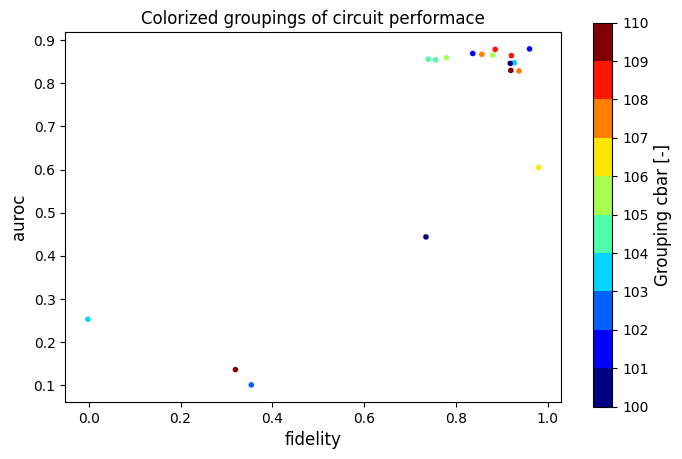



<style>

</style>

<div id="fig_el36648140540114196512562994152"></div>
<script>
function mpld3_load_lib(url, callback){
  var s = document.createElement('script');
  s.src = url;
  s.async = true;
  s.onreadystatechange = s.onload = callback;
  s.onerror = function(){console.warn("failed to load library " + url);};
  document.getElementsByTagName("head")[0].appendChild(s);
}

if(typeof(mpld3) !== "undefined" && mpld3._mpld3IsLoaded){
   // already loaded: just create the figure
   !function(mpld3){
       
       mpld3.draw_figure("fig_el36648140540114196512562994152", {"width": 640.0, "height": 480.0, "axes": [{"bbox": [0.125, 0.10999999999999999, 0.775, 0.77], "xlim": [0.005856575000000003, 1.013124925], "ylim": [0.11617641025641023, 0.9061005128205127], "xdomain": [0.005856575000000003, 1.013124925], "ydomain": [0.11617641025641023, 0.9061005128205127], "xscale": "linear", "yscale": "linear", "axes": [{"position": "bottom", "nticks": 7, "tickvalues": null, "tickformat_formatter":

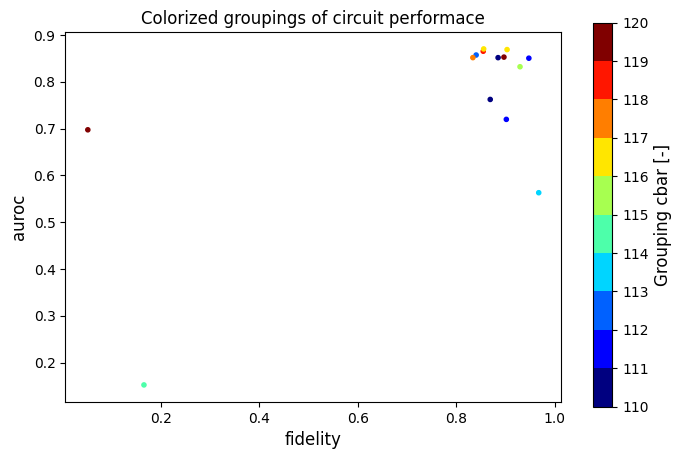



<style>

</style>

<div id="fig_el36648140540119731552196004769"></div>
<script>
function mpld3_load_lib(url, callback){
  var s = document.createElement('script');
  s.src = url;
  s.async = true;
  s.onreadystatechange = s.onload = callback;
  s.onerror = function(){console.warn("failed to load library " + url);};
  document.getElementsByTagName("head")[0].appendChild(s);
}

if(typeof(mpld3) !== "undefined" && mpld3._mpld3IsLoaded){
   // already loaded: just create the figure
   !function(mpld3){
       
       mpld3.draw_figure("fig_el36648140540119731552196004769", {"width": 640.0, "height": 480.0, "axes": [{"bbox": [0.125, 0.10999999999999999, 0.775, 0.77], "xlim": [-0.04087954999999992, 0.99855555], "ylim": [0.1177005128205128, 0.9138071794871795], "xdomain": [-0.04087954999999992, 0.99855555], "ydomain": [0.1177005128205128, 0.9138071794871795], "xscale": "linear", "yscale": "linear", "axes": [{"position": "bottom", "nticks": 7, "tickvalues": null, "tickformat_formatter": "",

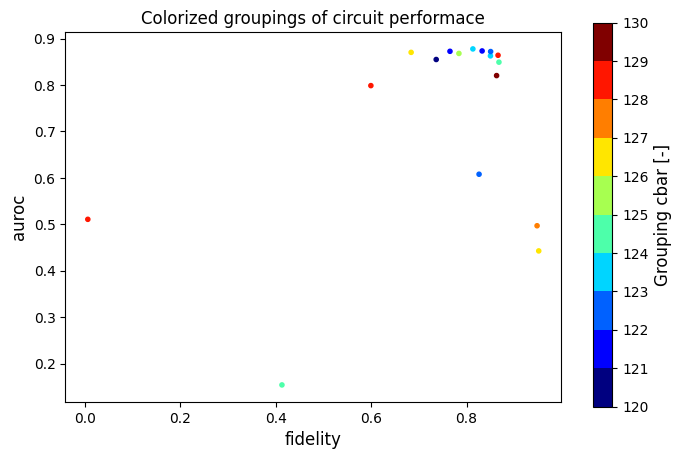



<style>

</style>

<div id="fig_el366481405401197017768085362871"></div>
<script>
function mpld3_load_lib(url, callback){
  var s = document.createElement('script');
  s.src = url;
  s.async = true;
  s.onreadystatechange = s.onload = callback;
  s.onerror = function(){console.warn("failed to load library " + url);};
  document.getElementsByTagName("head")[0].appendChild(s);
}

if(typeof(mpld3) !== "undefined" && mpld3._mpld3IsLoaded){
   // already loaded: just create the figure
   !function(mpld3){
       
       mpld3.draw_figure("fig_el366481405401197017768085362871", {"width": 640.0, "height": 480.0, "axes": [{"bbox": [0.125, 0.10999999999999999, 0.775, 0.77], "xlim": [0.51615975, 0.97496425], "ylim": [0.6187241025641026, 0.9162092307692308], "xdomain": [0.51615975, 0.97496425], "ydomain": [0.6187241025641026, 0.9162092307692308], "xscale": "linear", "yscale": "linear", "axes": [{"position": "bottom", "nticks": 6, "tickvalues": null, "tickformat_formatter": "", "tickformat": nul

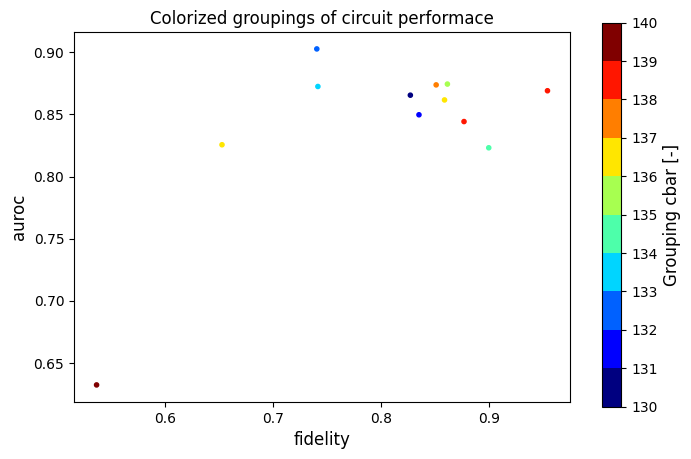



<style>

</style>

<div id="fig_el366481405401033576803686669857"></div>
<script>
function mpld3_load_lib(url, callback){
  var s = document.createElement('script');
  s.src = url;
  s.async = true;
  s.onreadystatechange = s.onload = callback;
  s.onerror = function(){console.warn("failed to load library " + url);};
  document.getElementsByTagName("head")[0].appendChild(s);
}

if(typeof(mpld3) !== "undefined" && mpld3._mpld3IsLoaded){
   // already loaded: just create the figure
   !function(mpld3){
       
       mpld3.draw_figure("fig_el366481405401033576803686669857", {"width": 640.0, "height": 480.0, "axes": [{"bbox": [0.125, 0.10999999999999999, 0.775, 0.77], "xlim": [-0.05500000000000001, 0.05500000000000001], "ylim": [-0.05500000000000001, 0.05500000000000001], "xdomain": [-0.05500000000000001, 0.05500000000000001], "ydomain": [-0.05500000000000001, 0.05500000000000001], "xscale": "linear", "yscale": "linear", "axes": [{"position": "bottom", "nticks": 7, "tickvalues": null, "

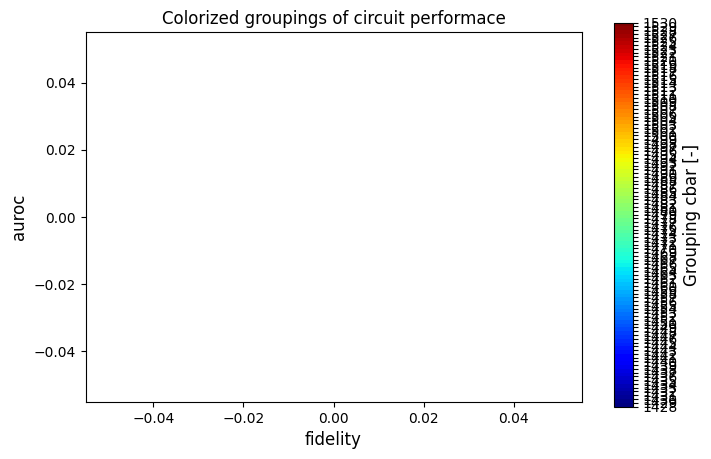

In [32]:
interactive_plot(str_ordering, str_groupings, 'string')

In [172]:
# line1_indeces = [293, 205, 186, 280, 172, 110, 1, 184, 203, 174, 275, 138, 330, 346, 361, 415, 299]
line1_indeces = [293, 205, 186, 280, 171, 172, 110, 1, 184, 203]
line2_indeces = [418, 357, 100, 331, 227]
line3_indeces = [30, 254, 372, 5, 156, 72, 409, 33, 394]

lines = [line1_indeces, line2_indeces, line3_indeces]

In [175]:
for line in lines:
    avg_distances = []
    for i in line:
        running_total = 0
        for j in line:
            running_total += euc_distances[i, j]
        avg_distances.append(running_total / len(line))

    print(f'average distances between circuits in line = {avg_distances}')
    for i in line:
        print('-'*30)
        print(f'fitness = {full_pop_fitness[i]:.03f}, auroc = {full_pop_auroc[i]:.03f}')
        print(full_pop_drawn_circuits[i])
    print('='*50)

average distances between circuits in line = [1.2213361569714172, 1.2558037044084556, 0.9804117759852243, 1.2319951164913796, 1.2110335766203448, 1.0923075005872858, 1.1604035274871052, 1.23703617695172, 1.2070309752600858, 1.3665359536945023]
------------------------------
fitness = 0.593, auroc = 0.139
0: ────────╭X──RY─╭●──┤     
1: ─╭●──RX─│───Rϕ─╰X──┤     
2: ─╰X─────╰●──RY──RZ─┤  
------------------------------
fitness = 0.639, auroc = 0.238
0: ─╭X─╭●──────╭●────┤     
1: ─│──╰X───RX─│──╭●─┤     
2: ─╰●──RZ─────╰X─╰X─┤  
------------------------------
fitness = 0.706, auroc = 0.366
0: ──RZ─┤     
1: ──RX─┤     
2: ──Rϕ─┤  
------------------------------
fitness = 0.735, auroc = 0.444
0: ─────╭X──RZ──Rϕ─┤     
1: ──RY─│───RX─────┤     
2: ─────╰●──RZ─────┤  
------------------------------
fitness = 0.739, auroc = 0.556
0: ─╭X─────╭X──RX─────┤     
1: ─╰●──RX─│───RZ─────┤     
2: ────────╰●──RX──RZ─┤  
------------------------------
fitness = 0.761, auroc = 0.556
0: ────────╭X──RX─

In [43]:
print(dict["per_gen_diversity"])

[1.5149303585311313, 1.607459531774855, 1.8654755320900258, 2.407539588965069, 1.5947903028776702, 1.9077285002500228, 1.7066501416516349, 1.9192326340850947, 2.587020188997861, 1.892903198650646, 2.0309356715588445, 2.474508118531861, 1.9813414278319406, 2.1566329845546535, 1.9806143967234917, 1.987383762795167, 2.2285567084070648, 1.9614432485115298, 2.666026924787483, 2.4350983146182625, 2.4758430383494545]
